TODOs

* Overlap metric, accuracy, computational use

* Position correction

* Scalar metric

* chapter 12 of https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632

misc notes:

clearing gpu memory: `for i in $(sudo lsof /dev/nvidia0 | grep python | awk '{print $2}' | sort -u); do sudo kill -9 $i; done`
https://github.com/tensorflow/tensorflow/issues/36465

### Training configuration:

In [3]:
from ptycho import params
h = w = N = params.cfg['N'] = 64
# offset between neighboring scan points, in pixels
offset = params.cfg['offset'] = 4
gridsize = params.cfg['gridsize'] = 2

nepochs=20
batch_size = params.cfg['batch_size'] = 16
train_probe = False

In [4]:
%matplotlib inline

import os
from ptycho import tf_helper as hh
from ptycho import fourier as f
from ptycho import datasets
from ptycho import physics
#from ptycho.params import params

from sklearn.utils import shuffle

from importlib import reload
import os

import tensorflow as tf

import tensorflow_addons as tfa

import importlib
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
# from tqdm.notebook import tqdm as tqdm

from tensorflow.keras.layers import Layer
from math import pi
from tensorflow.keras import backend as K

matplotlib.rcParams['font.size'] = 12

2023-01-13 18:10:30.508779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 18:10:30.759113: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-13 18:10:31.328326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-01-13 18:10:31.328555: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [5]:
!nvidia-smi

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Fri Jan 13 18:10:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   43C    P2   116W / 420W |    595MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

### Some training and probe parameters

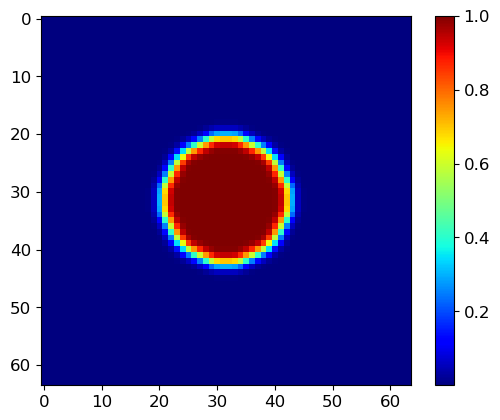

In [6]:
#filt = f.lowpass_g(.55, np.ones(N), sym = True)
filt = f.lowpass_g(.7, np.ones(N), sym = True)
#filt = f.lowpass_g(.9, np.ones(N), sym = True)

# TODO assert symmetry
probe = f.gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 1) + 1e-9
probe_small = probe[16:-16, 16:-16]
tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])
tprobe_small = (tf.convert_to_tensor(probe_small, tf.float32)[..., None])

# if (not os.path.isdir(path+wt_path)):
#     os.mkdir(wt_path)

# plt.imshow(tprobe_small, cmap = 'jet')
plt.imshow(tprobe, cmap = 'jet')
plt.colorbar()

### Simulate ptychography data

In [7]:
bigoffset = (gridsize - 1) * offset + N // 2
big_gridsize = 10
bigN = params.params()['bigN']
size = bigoffset * (big_gridsize - 1) + bigN

bigoffset = params.cfg['bigoffset'] = ((gridsize - 1) * offset + N // 2) // 2

In [8]:
np.random.seed(1)

X_train, Y_I_train, Y_phi_train, intensity_scale, _Y_I_train_full, _  = datasets.mk_simdata(9, size, probe)
# X_train, Y_I_train, Y_phi_train, intensity_scale, _Y_I_train_full, _  = datasets.mk_simdata(1, size, probe)
params.cfg['intensity_scale'] = intensity_scale

np.random.seed(2)
X_test, Y_I_test, Y_phi_test, _, _Y_I_test_full, norm_Y_I_test = datasets.mk_simdata(3, size, probe, intensity_scale)
# X_test, Y_I_test, Y_phi_test, _, _Y_I_test_full, norm_Y_I_test = datasets.mk_simdata(1, size, probe, intensity_scale)

# TODO shuffle should be after flatten
X_train, Y_I_train, Y_phi_train = shuffle(X_train.numpy(), Y_I_train.numpy(), Y_phi_train.numpy(), random_state=0)

(Y_I_test).shape, Y_I_train.shape


Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


(TensorShape([4107, 64, 64, 4]), (12321, 64, 64, 4))

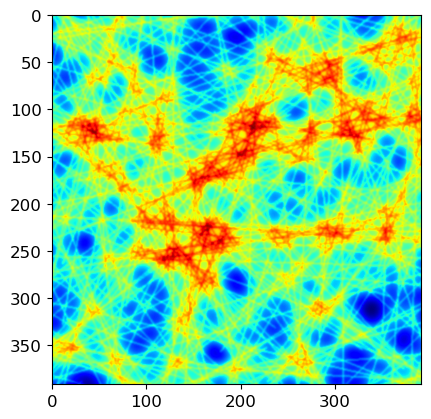

In [9]:
plt.imshow(_Y_I_train_full[0], cmap = 'jet')

In [10]:
print('intensity scale:', intensity_scale, '\n',
      'max photon count:', (np.max(Y_I_train, axis = (1, 2, 3)).mean() * intensity_scale)**2, '\n',
      'shapes:', (Y_phi_test).shape, (Y_I_test).shape, Y_I_train.shape)

intensity scale: 2531.8667011260686 
 max photon count: 4661058.100453542 
 shapes: (4107, 64, 64, 4) (4107, 64, 64, 4) (12321, 64, 64, 4)


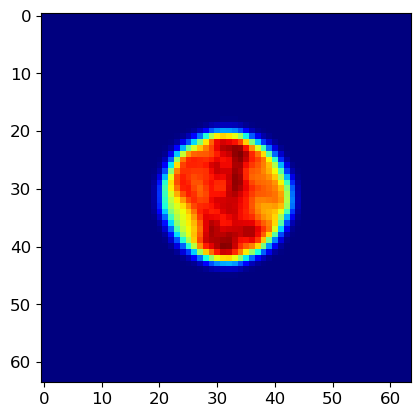

In [11]:
plt.imshow(Y_I_train[0, :, :, 0], cmap = 'jet')

### Norm conservation consistency check:

In [12]:
print(np.linalg.norm(X_train[0]) /  np.linalg.norm(Y_I_train[0]))

def normed_ff_np(arr):
    return (f.fftshift(np.absolute(f.fft2(np.array(arr)))) / np.sqrt(h * w))

0.9999965


### Inversion symmetry check:

In [13]:
assert np.isclose(normed_ff_np(Y_I_train[0, :, :, 0]),
            tf.math.conj(normed_ff_np(Y_I_train[0, ::-1, ::-1, 0])), atol = 1e-6).all()

#normed_ff_np(Y_I_train[0, :, :, 0]).sum() / normed_ff_np(Y_I_train[0, :, :, 0]).sum()

### np / tf consistency check:

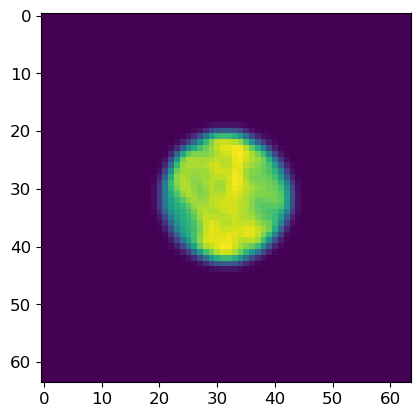

In [14]:
plt.imshow(Y_I_train[0, :, :, 0])

In [15]:
intensity_scale

2531.8667011260686

### Number of photons consistency check

In [16]:
np.log10(np.sum((X_train[:, :, :] * intensity_scale)**2, axis = (1, 2))).mean()

8.976986

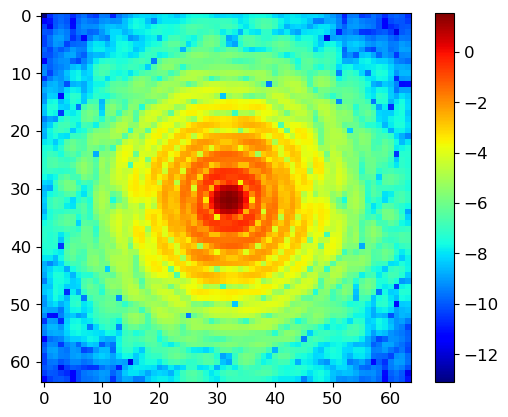

In [17]:
i = 1

plt.imshow(np.log(normed_ff_np
                  (np.array(hh.combine_complex(Y_I_train, Y_phi_train))[0, :, :, 0])), cmap = 'jet')
plt.colorbar()

/tmp/ipykernel_3585993/2642748978.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_train[0, :, :, 0]), cmap = 'jet')


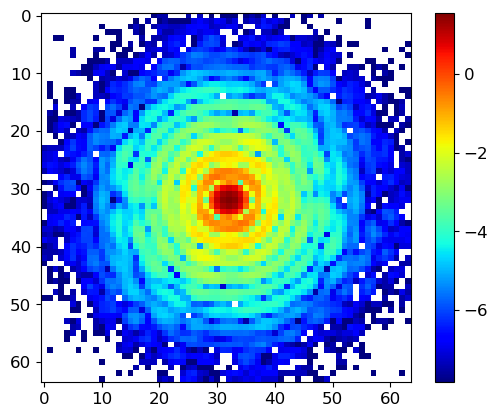

In [18]:
plt.imshow(np.log(X_train[0, :, :, 0]), cmap = 'jet')
plt.colorbar()

In [19]:
tmp = X_train.mean(axis = (0, 3))
probe_fif = np.absolute(f.fftshift(f.ifft2(f.ifftshift(tmp))))[N // 2, :]

# variance increments of a slice down the middle
d_second_moment = (probe_fif / probe_fif.sum()) * ((np.arange(N) - N // 2)**2)
probe_sigma_guess = np.sqrt(d_second_moment.sum())

from scipy import signal

centered_indices = np.arange(N) - N // 2 + .5
x, y = np.meshgrid(centered_indices, centered_indices)
d = np.sqrt(x*x+y*y)
mu = 0.
probe_mask = (d < N // 4)
probe_guess = np.exp(-( (d-mu)**2 / ( 2.0 * probe_sigma_guess**2 ) ) )
probe_guess *= probe_mask
probe_guess *= (np.sum(tprobe) / np.sum(probe_guess))

# probe_guess = np.ones_like(probe_sigma_guess) * probe_mask
# probe_guess *= (np.sum(tprobe) / np.sum(probe_guess))

t_probe_guess = tf.convert_to_tensor(probe_guess, tf.float32)[..., None]

In [20]:
if train_probe:
    params.cfg['probe'] = t_probe_guess
    params.cfg['probe.trainable'] = True
else:
    params.cfg['probe'] = tprobe
    params.cfg['probe.trainable'] = False

params.cfg['probe_mask'] = tf.convert_to_tensor(probe_mask, tf.complex64)[..., None]

## Define the network structure

In [24]:
from ptycho import params

In [27]:
from ptycho import model
# reload(hh)
# reload(model.hh)
# reload(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 intensity_scaler (IntensitySca  (None, 64, 64, 4)   1           ['input[0][0]']                  
 ler)                                                                                             
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   2368        ['intensity_scaler[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']             

                                                                                                  
Total params: 4,404,873
Trainable params: 4,400,777
Non-trainable params: 4,096
__________________________________________________________________________________________________
None


In [28]:
from datetime import datetime
from packaging import version

import os
#Create a TensorBoard callback
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

2023-01-13 18:17:17.064487: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-01-13 18:17:17.064508: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-01-13 18:17:17.155121: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-01-13 18:17:17.155220: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


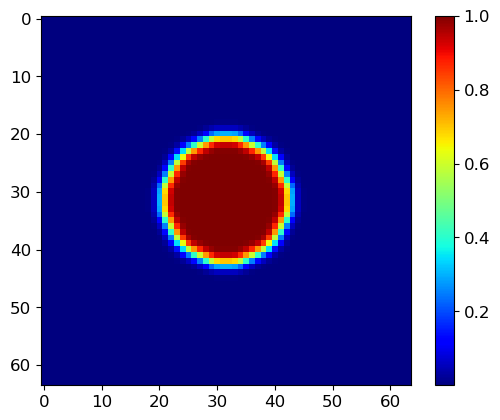

In [29]:
plt.imshow(np.absolute(model.autoencoder.variables[-1]), cmap = 'jet')
plt.colorbar()

In [30]:
# for i, v in enumerate(model.autoencoder.variables):
#     print(i, v.shape)

In [31]:
# other_layers = hh.get_layers_except(model.autoencoder, 'probe_illumination')
# pi_layer = model.autoencoder.get_layer('probe_illumination')
# base_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# fast_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
# optimizers_and_layers = [(base_optimizer, other_layers), (fast_optimizer, pi_layer)]
# optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

In [ ]:
history = model.train(40, X_train, Y_I_train)#tboard_callback
b, a, reg, L2_error = model.autoencoder.predict([X_test * model.params()['intensity_scale']])

Epoch 1/40


2023-01-13 18:17:27.964448: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


732/732 [==============================] - 17s 19ms/step - loss: 82892088.0000 - trimmed_obj_loss: 0.1327 - pred_diff_channels_loss: 85.2359 - distribution_lambda_loss: 82892088.0000 - probe_illumination_loss: 0.0047 - val_loss: 50008024.0000 - val_trimmed_obj_loss: 0.1291 - val_pred_diff_channels_loss: 84.5563 - val_distribution_lambda_loss: 50008024.0000 - val_probe_illumination_loss: 0.0047 - lr: 0.0010
Epoch 2/40
732/732 [==============================] - 13s 17ms/step - loss: 29866140.0000 - trimmed_obj_loss: 0.1221 - pred_diff_channels_loss: 85.2379 - distribution_lambda_loss: 29866140.0000 - probe_illumination_loss: 0.0047 - val_loss: 18941278.0000 - val_trimmed_obj_loss: 0.1162 - val_pred_diff_channels_loss: 84.5590 - val_distribution_lambda_loss: 18941278.0000 - val_probe_illumination_loss: 0.0047 - lr: 0.0010
Epoch 3/40
732/732 [==============================] - 13s 17ms/step - loss: 16985280.0000 - trimmed_obj_loss: 0.1123 - pred_diff_channels_loss: 85.2392 - distribution_la

Epoch 20/40
732/732 [==============================] - 13s 17ms/step - loss: 2547520.5000 - trimmed_obj_loss: 0.1171 - pred_diff_channels_loss: 85.2388 - distribution_lambda_loss: 2547520.5000 - probe_illumination_loss: 0.0047 - val_loss: 5879692.0000 - val_trimmed_obj_loss: 0.1170 - val_pred_diff_channels_loss: 84.5583 - val_distribution_lambda_loss: 5879692.0000 - val_probe_illumination_loss: 0.0047 - lr: 5.0000e-04
Epoch 21/40
729/732 [============================>.] - ETA: 0s - loss: 2492920.5000 - trimmed_obj_loss: 0.1180 - pred_diff_channels_loss: 85.2430 - distribution_lambda_loss: 2492920.5000 - probe_illumination_loss: 0.0047
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
732/732 [==============================] - 13s 17ms/step - loss: 2492589.0000 - trimmed_obj_loss: 0.1180 - pred_diff_channels_loss: 85.2386 - distribution_lambda_loss: 2492589.0000 - probe_illumination_loss: 0.0047 - val_loss: 3518377.7500 - val_trimmed_obj_loss: 0.1174 - val_pre

In [33]:
len(history.history['loss'])

40

In [24]:
b, a, reg, L2_error = model.autoencoder.predict([X_test * model.params()['intensity_scale']])

129/129 [==============================] - 8s 58ms/step


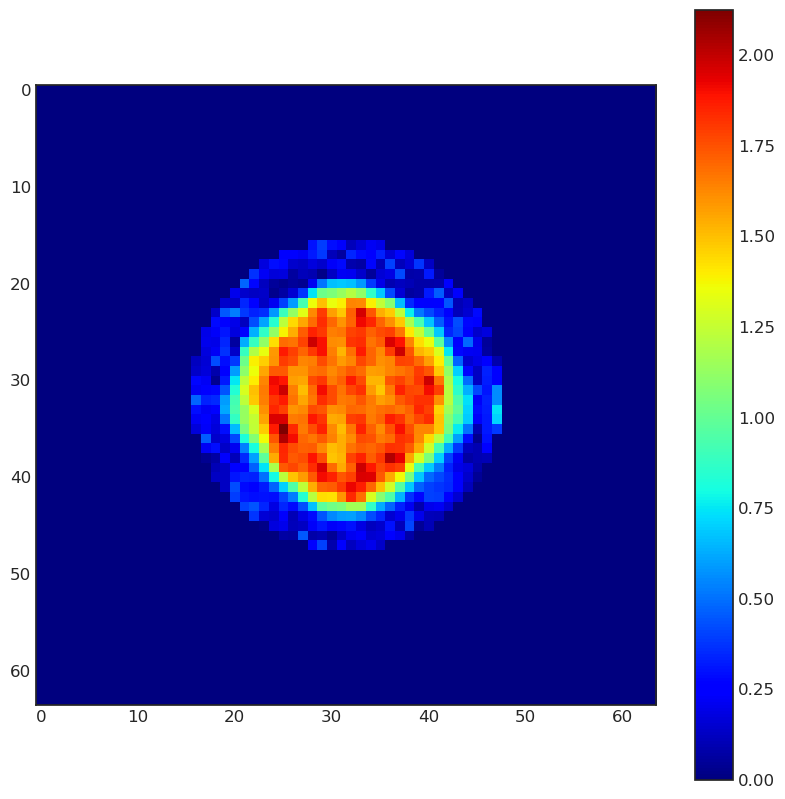

In [32]:
plt.imshow(np.absolute(model.autoencoder.variables[-1]), cmap = 'jet')
plt.colorbar()

In [37]:
model.autoencoder.variables[-1].shape

TensorShape([64, 64, 1])

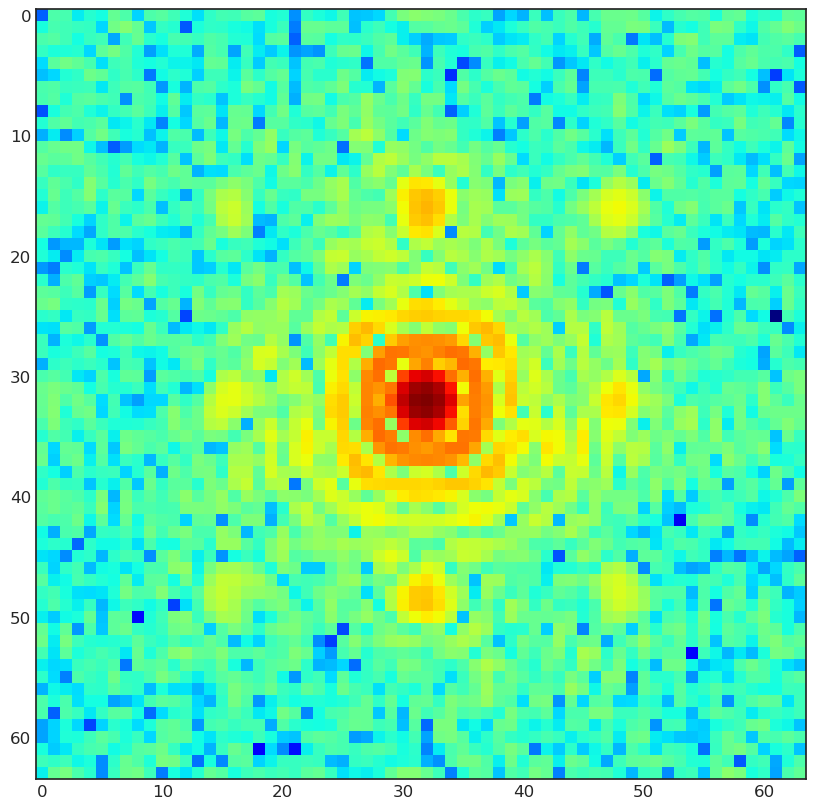

In [33]:
tmp = np.absolute(f.fftshift(f.fft2(np.array(model.autoencoder.variables[-1][:, :, 0]))))
plt.imshow(np.log(tmp),
          cmap  ='jet')

In [ ]:
plt.imshow(np.absolute(
    hh.anti_alias_complex(model.autoencoder.variables[-1])
), cmap = 'jet')
plt.colorbar()

In [101]:
%load_ext tensorboard

In [103]:
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 408134), started 0:01:09 ago. (Use '!kill 408134' to kill it.)

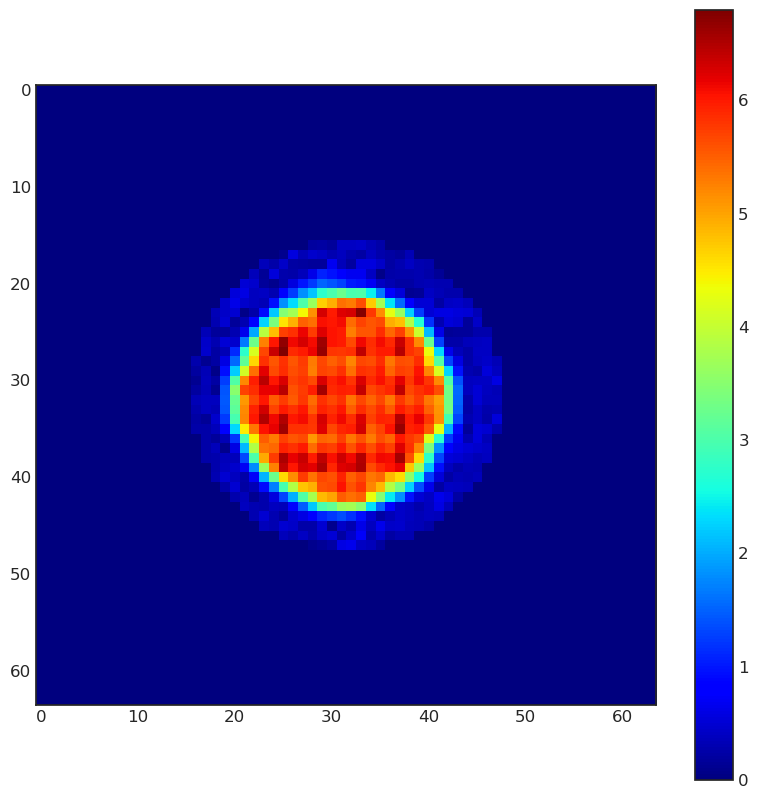

In [53]:
plt.imshow(np.absolute(model.autoencoder.variables[-1]), cmap = 'jet')
plt.colorbar()

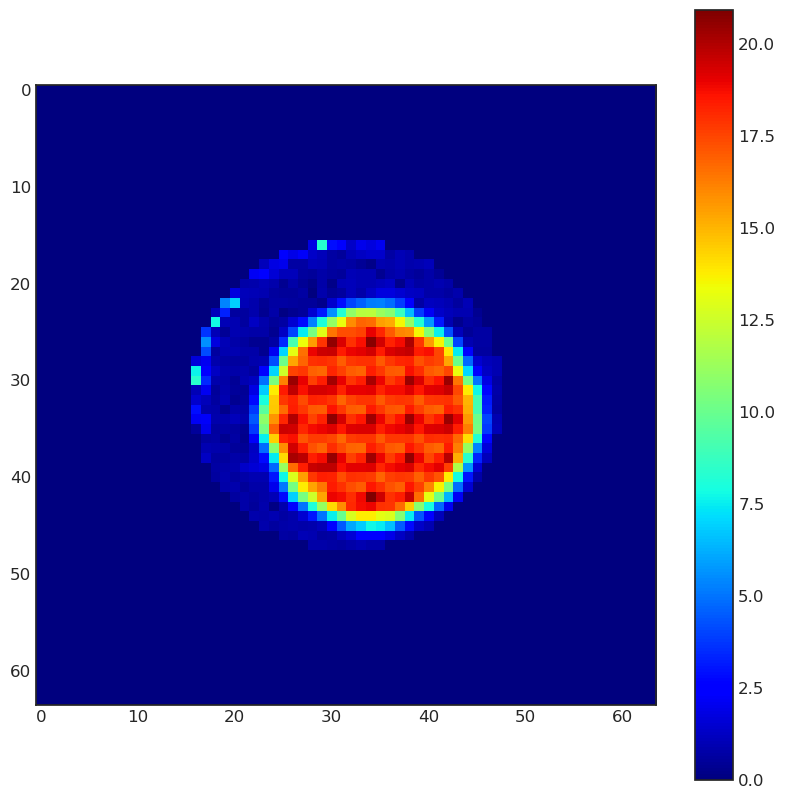

In [43]:
plt.imshow(np.absolute(model.autoencoder.variables[-1]), cmap = 'jet')
plt.colorbar()

In [26]:
# %timeit model.diffraction_to_obj.predict([X_test])

# %timeit autoencoder.predict([X_test])

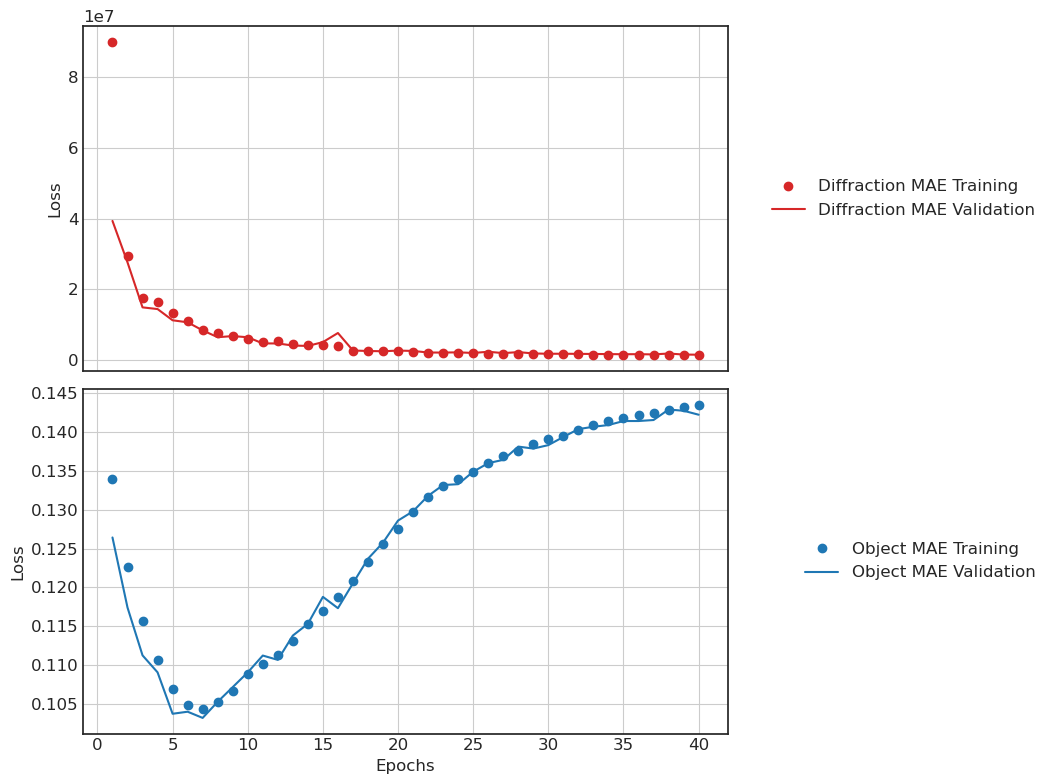

In [37]:
from ptycho import evaluation
reload(evaluation)

evaluation.plt_metrics(history, metric2 = 'trimmed_obj_loss')

In [65]:
tmp = np.random.uniform(size = N**2).reshape((N, N, 1))

In [66]:
tmp = tf.image.resize(tmp, (N // 2, N // 2), antialias=True)

tmp = tf.image.resize(tmp, (N, N), antialias=True)

In [69]:
reload(hh)

<module 'ptycho.tf_helper' from '/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/tf_helper.py'>

In [76]:
probe_mask.shape

(64, 64)

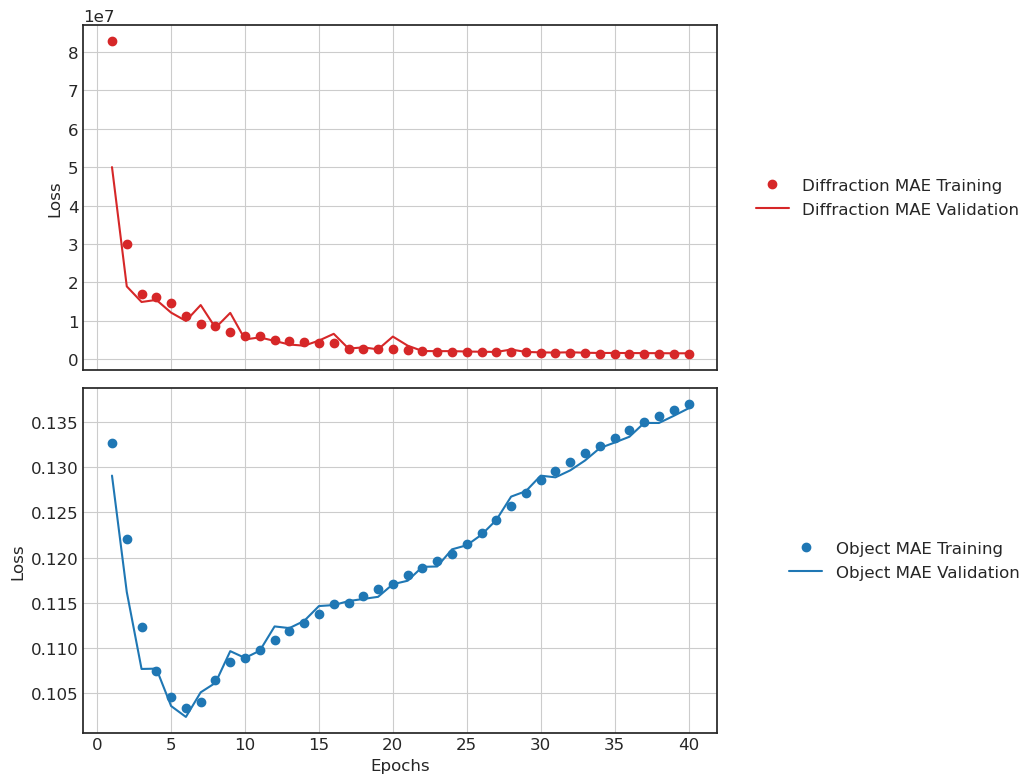

In [34]:
from ptycho import evaluation
reload(evaluation)

evaluation.plt_metrics(history, metric2 = 'trimmed_obj_loss')

In [30]:
from ptycho import evaluation
reload(evaluation)

evaluation.plt_metrics(history, metric2 = 'trimmed_obj_loss')

In [39]:
reload(evaluation)

<module 'ptycho.evaluation' from '/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py'>

phase min: -0.1484967 phase max: 0.0


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


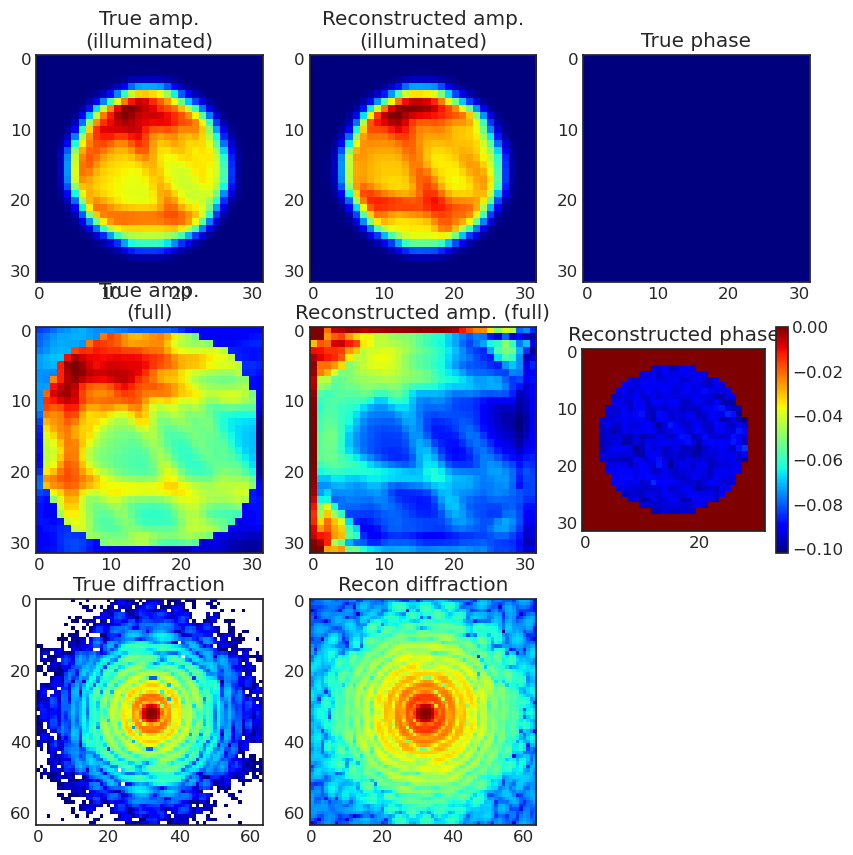

In [39]:
#plt_metrics()
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

phase min: -0.8391597 phase max: 1.0607026


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


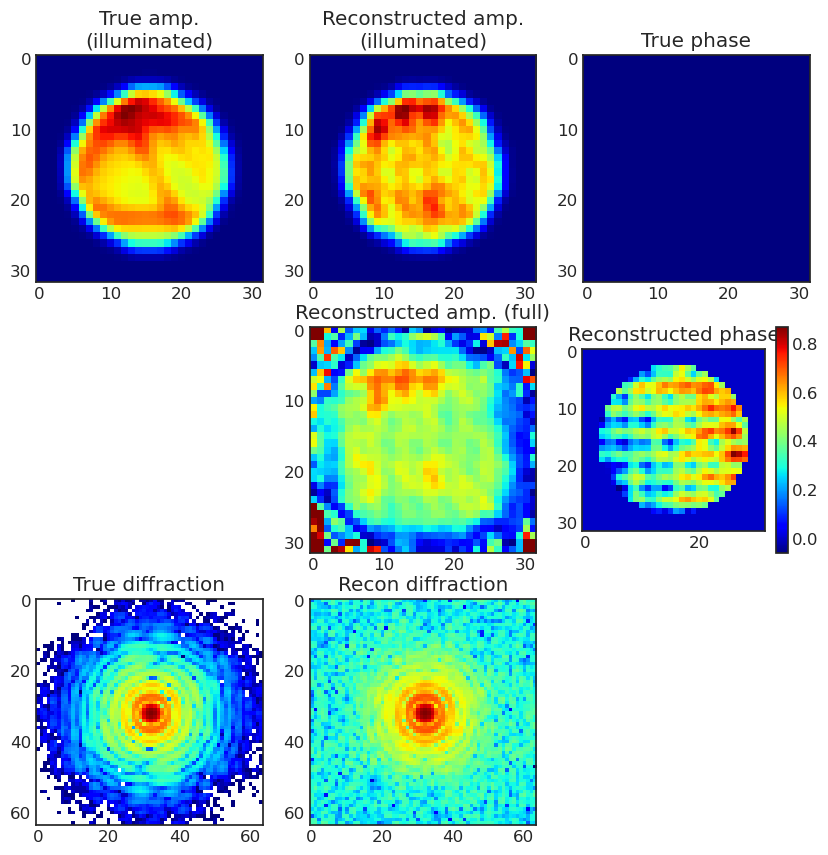

In [28]:
#plt_metrics()
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

phase min: -0.89512324 phase max: 0.5467879


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:60: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


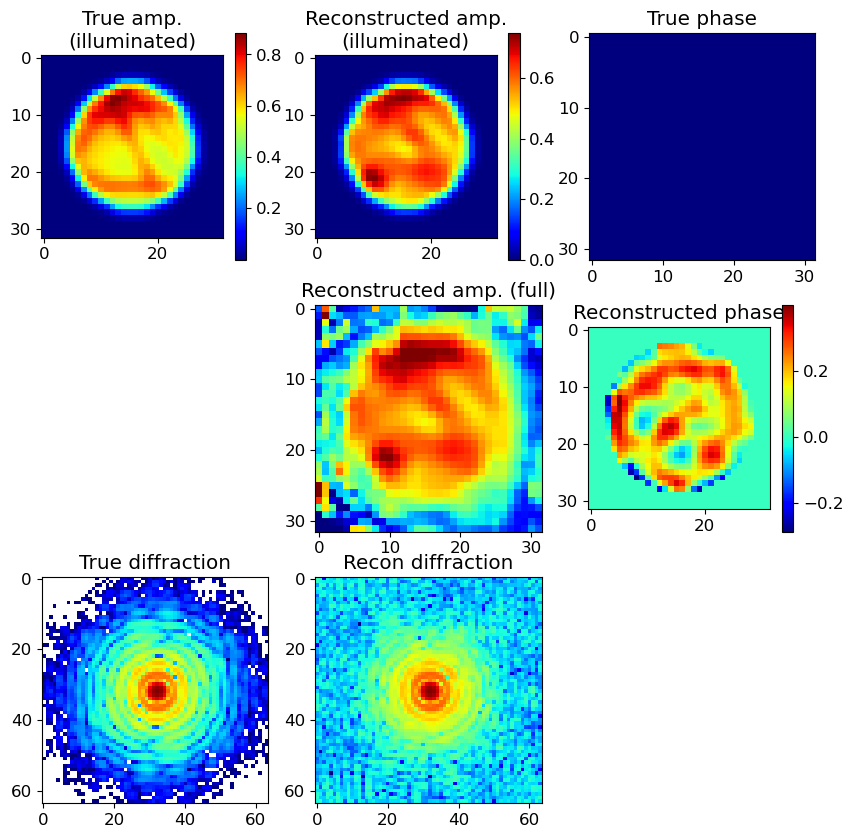

In [39]:
#plt_metrics()
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

phase min: -2.310916 phase max: 0.0


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


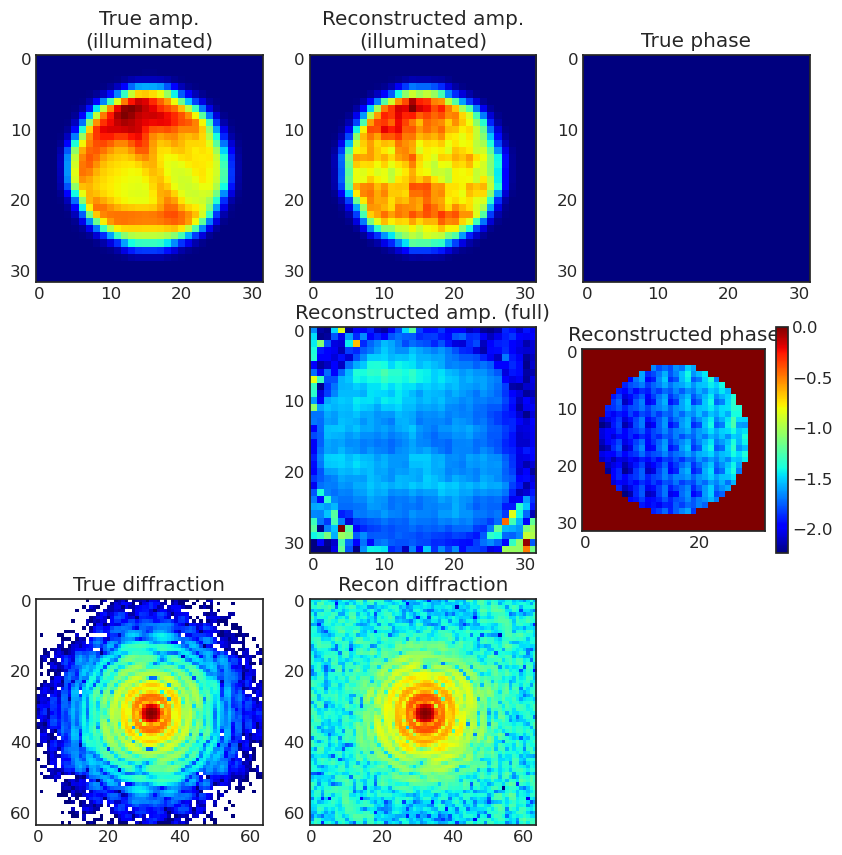

In [55]:
#plt_metrics()
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

phase min: -3.1415248 phase max: 3.1415508


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


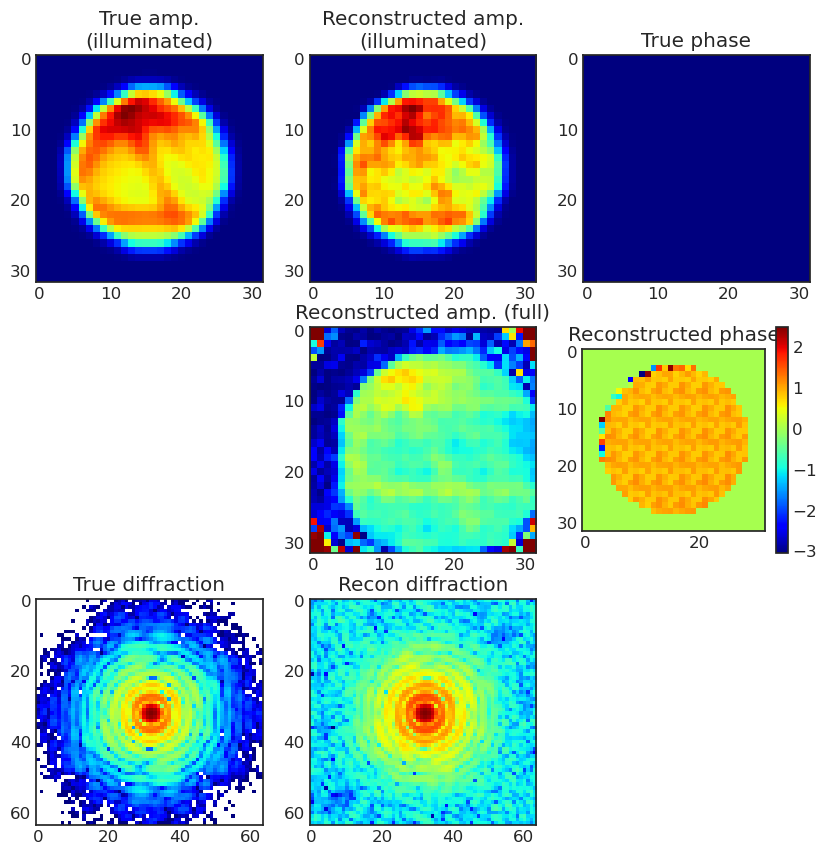

In [42]:
#plt_metrics()
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

phase min: -0.09522999 phase max: 0.07269313


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


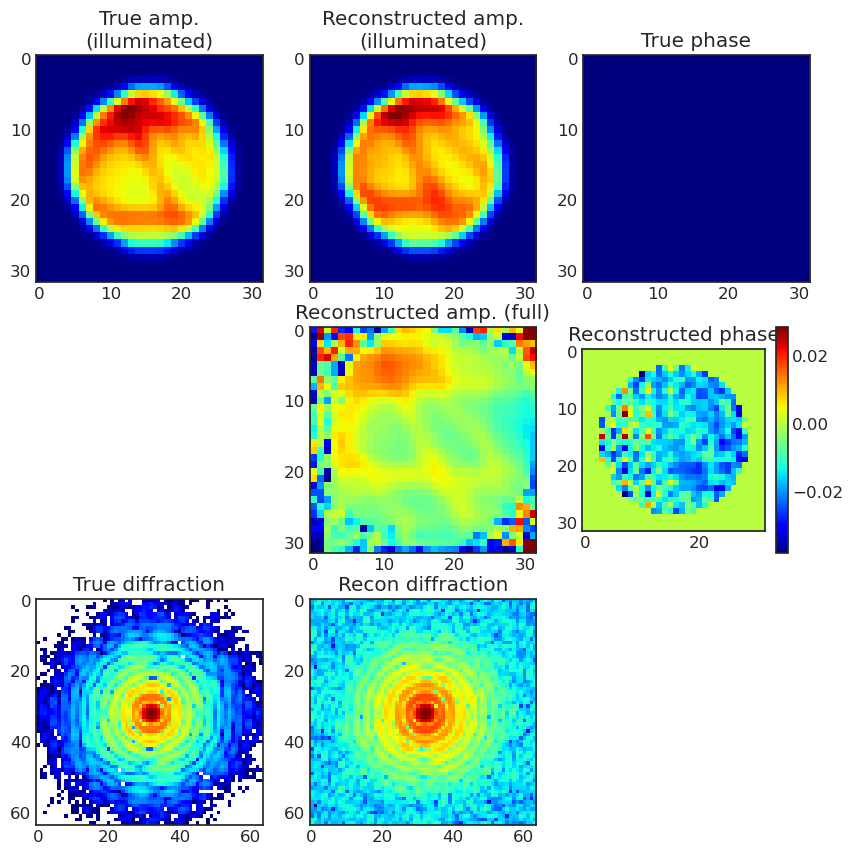

In [28]:
#plt_metrics()
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

In [42]:
from ptycho import baselines as bl
from ptycho.params import params

In [91]:
bigoffset = params()['bigoffset']
bordersize = (N - bigoffset / 2) / 2
borderleft = int(np.ceil(bordersize))
borderright = int(np.floor(bordersize))

clipsize = (bordersize + ((gridsize - 1) * offset) // 2)
clipleft = int(np.ceil(clipsize))
clipright = int(np.floor(clipsize))

def stitch(b, norm_Y_I_test = 1,
           nsegments = (size - bigN) // (bigoffset // 2) + 1,
           norm = True):
    if norm:
        img_recon = np.reshape((norm_Y_I_test * np.absolute(b)), (-1, nsegments,
                                                              nsegments, 64, 64, 1))
    else:
        img_recon = np.reshape((norm_Y_I_test * np.absolute(b)), (-1, nsegments,
                                                              nsegments, 64, 64, 1))
    img_recon = img_recon[:, :, :, borderleft: -borderright, borderleft: -borderright, :]
    tmp = img_recon.transpose(0, 1, 3, 2, 4, 5)
    stitched = tmp.reshape(-1, np.prod(tmp.shape[1:3]), np.prod(tmp.shape[1:3]), 1)
    return stitched

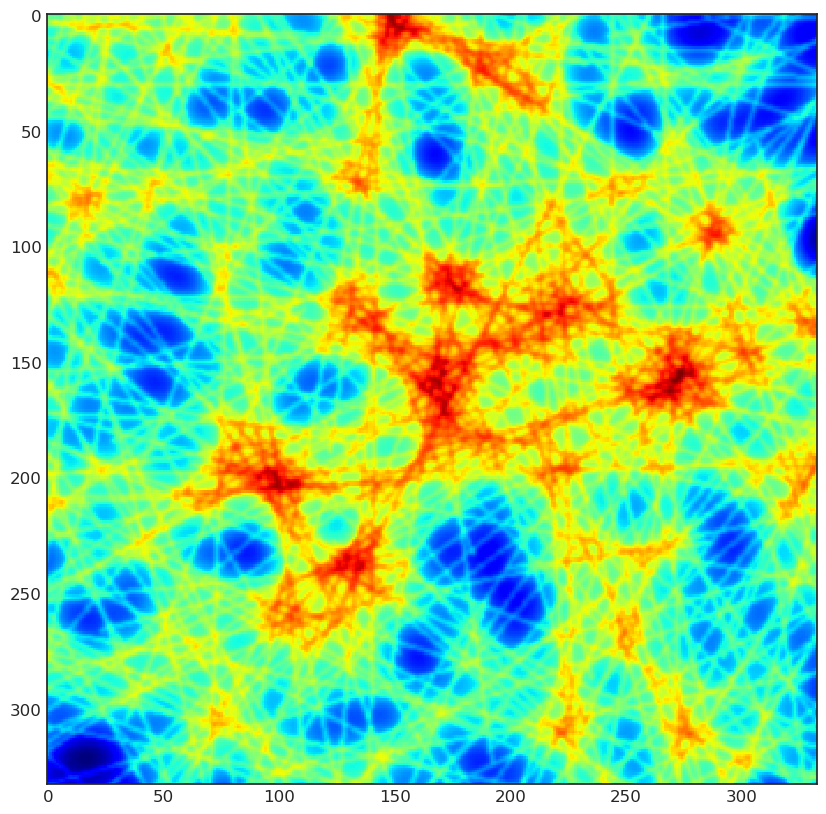

In [92]:
bordersize = N // 2 - bigoffset // 4
clipsize = (bordersize + ((gridsize - 1) * offset) // 2)

plt.imshow(_Y_I_test_full[0, clipleft: -clipright, clipleft: -clipright], interpolation = 'none',
          cmap = 'jet')
vmin = np.min(_Y_I_test_full[0, clipleft: -clipright, clipleft: -clipright])
vmax = np.max(_Y_I_test_full[0, clipleft: -clipright, clipleft: -clipright])

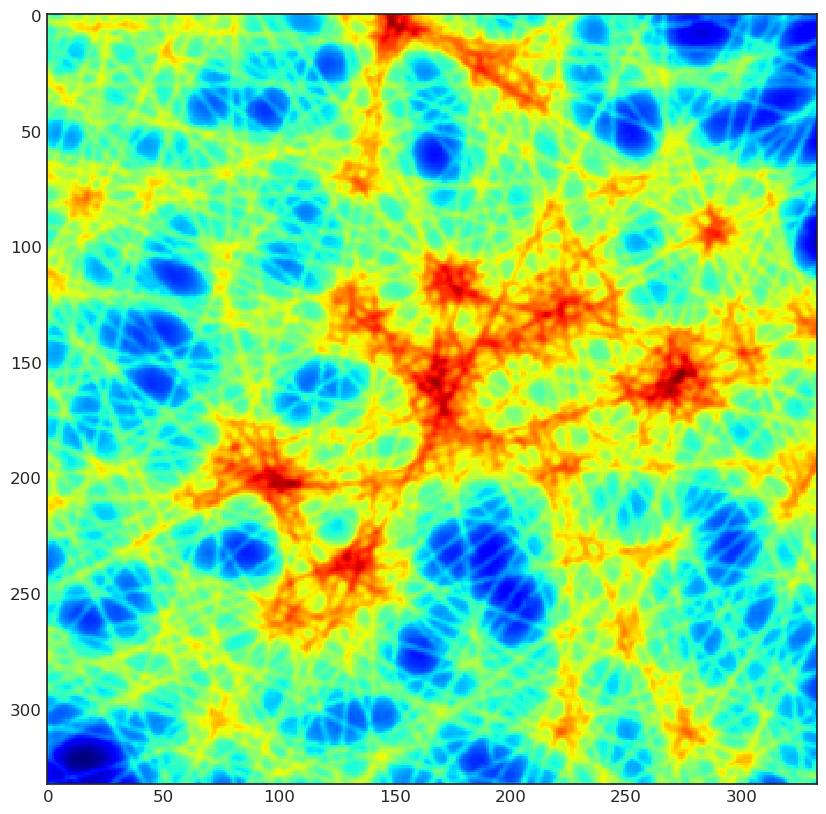

In [93]:
plt.rcParams["figure.figsize"] = (10, 10)

stitched = stitch(b, norm_Y_I_test,
                  #nsegments=37,
                  norm = False)

plt.imshow(stitched[0], interpolation = 'none', cmap = 'jet')
#plt.imshow(stitched[0], interpolation = 'none', vmin = vmin, vmax = vmax, cmap = 'jet')

In [96]:
_Y_I_test_full[0, clipleft: -clipright, clipleft: -clipright].shape, stitched.shape

((333, 333, 1), (3, 333, 333, 1))

In [99]:
tf.image.psnr(_Y_I_test_full[:, clipleft: -clipright, clipleft: -clipright], stitched, peakval)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([20.983551, 20.986797, 21.238514], dtype=float32)>

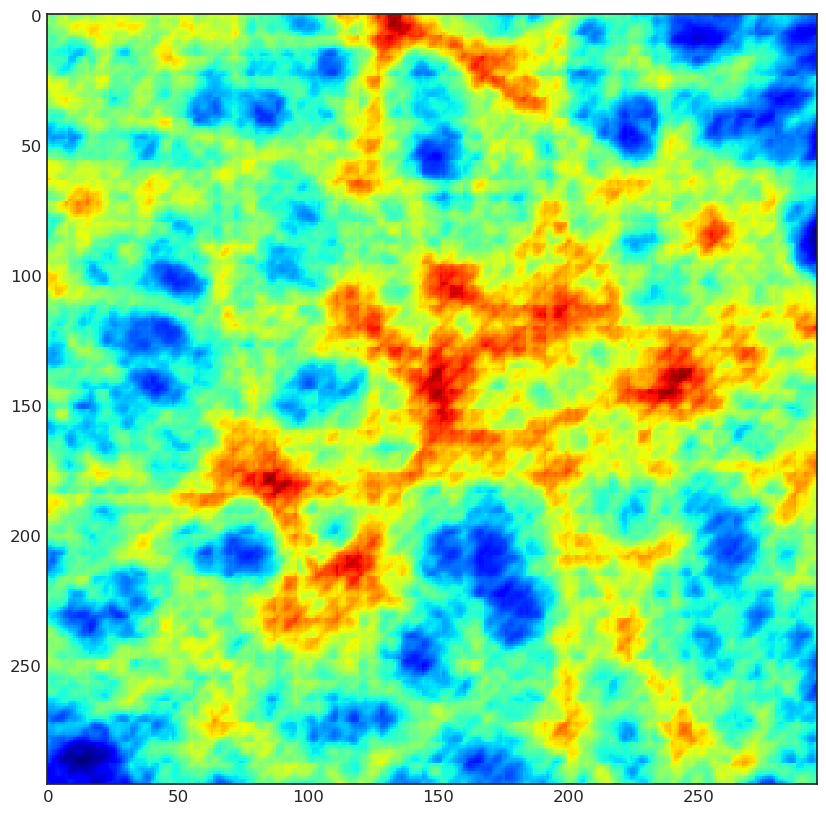

In [63]:
plt.rcParams["figure.figsize"] = (10, 10)

stitched = stitch(b, norm_Y_I_test, nsegments=37, norm = False)

plt.imshow(stitched[0], interpolation = 'none', cmap = 'jet')
#plt.imshow(stitched[0], interpolation = 'none', vmin = vmin, vmax = vmax, cmap = 'jet')

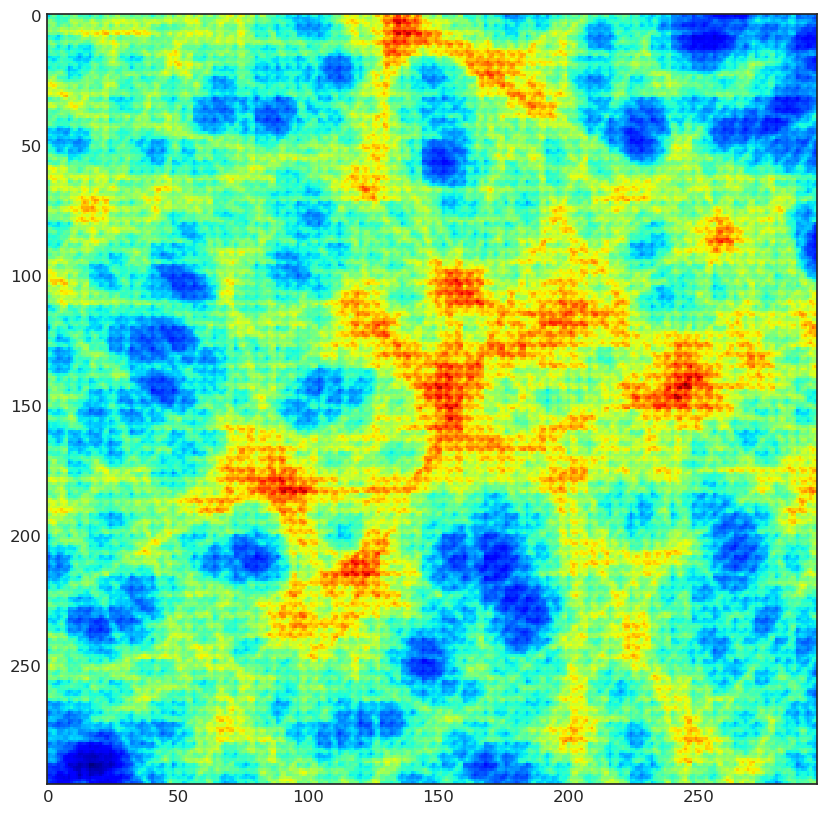

In [47]:
plt.rcParams["figure.figsize"] = (10, 10)

stitched = stitch(b, norm_Y_I_test, nsegments=37, norm = False)

plt.imshow(stitched[0], interpolation = 'none', cmap = 'jet')
#plt.imshow(stitched[0], interpolation = 'none', vmin = vmin, vmax = vmax, cmap = 'jet')

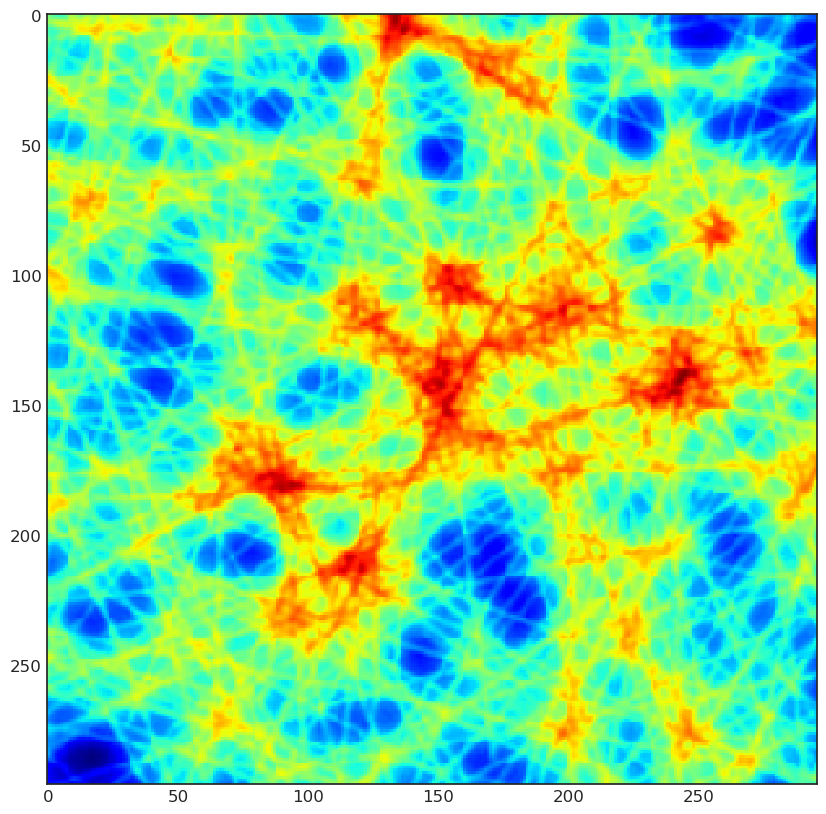

In [38]:
plt.rcParams["figure.figsize"] = (10, 10)

stitched = stitch(b, norm_Y_I_test, nsegments=37, norm = False)

plt.imshow(stitched[0], interpolation = 'none', cmap = 'jet')
#plt.imshow(stitched[0], interpolation = 'none', vmin = vmin, vmax = vmax, cmap = 'jet')

In [39]:
bl.nepochs = 20

In [40]:
baseline_model = bl.train((X_train[:, :, :, :1]), Y_I_train[:, :, :, :1], Y_phi_train[:, :, :, :1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

129/129 [==============================] - 1s 4ms/step


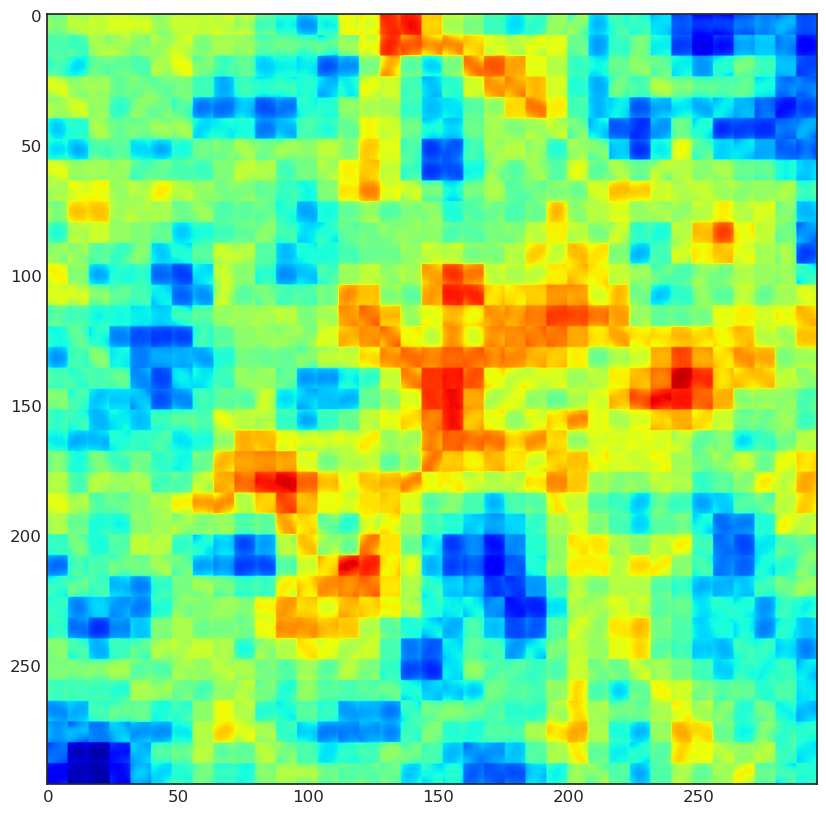

In [41]:
baseline_pred_I, baseline_pred_phi = baseline_model.predict([X_test[:, :, :, 0]])
baseline_stitched = stitch(baseline_pred_I, norm_Y_I_test, nsegments=37)

plt.imshow(baseline_stitched[0], cmap = 'jet', vmin = vmin, vmax = vmax)

In [47]:
# gt = _Y_I_test_full[:, clipsize: -clipsize, clipsize: -clipsize]
# tf.keras.losses.MeanAbsoluteError()(gt, stitched)

# tf.keras.losses.MeanSquaredError()(gt, stitched)

# tf.keras.losses.MeanAbsoluteError()(gt, baseline_stitched)

# tf.keras.losses.MeanSquaredError()(gt, baseline_stitched)

In [42]:
i = 0
# consistency check: should be close to equal
np.sum(tf.math.abs(a[i])**2), np.sum(tf.math.abs(X_test[i])**2),\
np.sum(tf.math.abs(a)**2), np.sum(tf.math.abs(X_test)**2)

(684.1687, 749.7991, 2316089.5, 2534097.2)

## Relative error of diffraction amplitude:

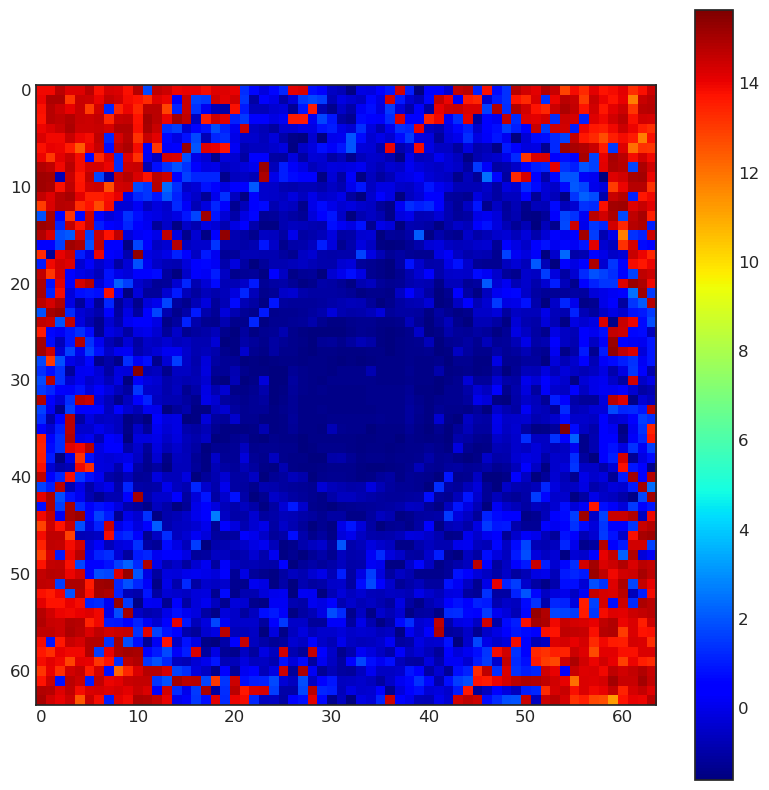

In [43]:
plt.imshow(np.log(.2 + np.abs((a[i, :, :, 0] - X_test[i, :, :, 0]) / (X_test[i, :, :, 0] + 1e-9))), cmap ='jet')
plt.colorbar()

In [45]:
# !ln ../xrd_clustering/notebooks/visualization.py
from ptycho import visualization as vis
reload(vis)

<module 'ptycho.visualization' from '/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/visualization.py'>

diffraction reconstruction


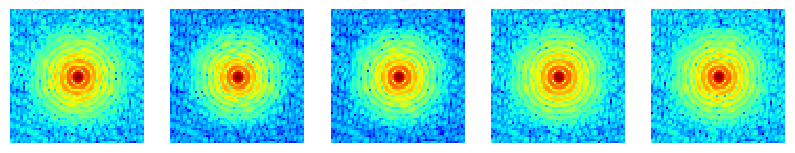

diffraction ground truth


/tmp/ipykernel_2102395/1178352548.py:10: RuntimeWarning: divide by zero encountered in log
  vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + off])


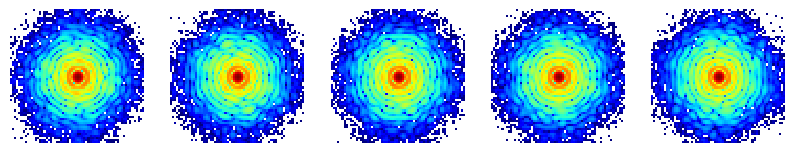

object reconstruction (amp)


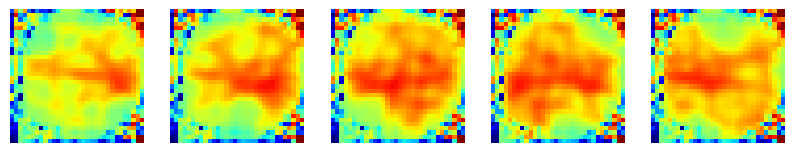

object ground truth


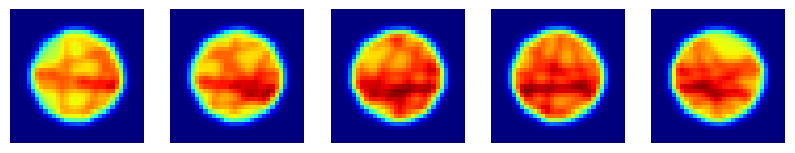

In [46]:
off = 5

vmin = np.min(Y_I_test[:, 16:-16, 16:-16][i:i + off])
vmax = np.max(Y_I_test[:, 16:-16, 16:-16][i:i + off])

print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a[:, :, :, 0]))[i:i + off])

print('diffraction ground truth')
vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + off])

print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16, 0])[i:i + off], vmin = vmin, vmax = vmax)
# print('object reconstruction (phase)')
# vis.display_imgs(np.angle(b[:, 16:-16, 16:-16, 0])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16, 0][i:i + off], vmin = vmin, vmax = vmax)

In [47]:
# Evaluate resolution

# np.random.seed(2)
# Y_I_2, Y_phi_2, _Y_I_full_2, _ = datasets.simulate_objects(3, size)

# line = np.zeros_like(Y_I_2)
# line[:, 31, :, :] = .1
# line = f.gf(line, (0, 1, 1, 0))


# X_2, Y_I_2, Y_phi_2, _ =\
#     physics.illuminate_and_diffract(Y_I_2 + line, Y_phi_2, probe, intensity_scale = intensity_scale)

# plt.imshow((Y_I_2 - Y_I_test)[0, :, :, 0])
# plt.colorbar()

# b2 = model.diffraction_to_obj([X_2])
# difference = np.real(b2 - model.diffraction_to_obj([X_test])).mean(axis = 0)

# plt.imshow(difference, cmap = 'jet')

# lineout_orig = line[0, :, :, 0].sum(axis = 1)
# lineout_recon = difference[:, :, 0].sum(axis = 1)

## save model

In [48]:
history.history.keys()

dict_keys(['loss', 'trimmed_obj_loss', 'pred_diff_channels_loss', 'distribution_lambda_loss', 'trimmed_obj_1_loss', 'val_loss', 'val_trimmed_obj_loss', 'val_pred_diff_channels_loss', 'val_distribution_lambda_loss', 'val_trimmed_obj_1_loss', 'lr'])

In [50]:
# np.save(path+'str_history2', history.history)

In [251]:
# model.load_weights(checkpoint_filepath)

In [68]:
# autoencoder.save('{}.h5'.format(wt_path))